<a href="https://colab.research.google.com/github/ubaldinho/Hello_World/blob/main/td_intro_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 1: Fairness notion and data analysis

In this first TD we are going to manipulate some data and see the behaviour of the different fairness metrics

## Objectives


 1. Study the data, the distribution of each feature and its relation to the target.

 2. Highlight some bias present in the data


## Installation of the environnement

We highly recommend you to follow these steps, it will allow every student to work in an environment as similar as possible to the one used during testing.

### Colab Settings
  The next two cells of code are too execute only once per colab environment


#### 1. Python env creation

        ```
        ! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```

#### 2. Download MEPS dataset (for part2) it can take several minutes

        ```
        ! Rscript /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/generate_data.R
        ! mv h181.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/
        ! mv h192.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/
        ```

  
### Local Settings

#### 1. Uv installation


        https://docs.astral.sh/uv/getting-started/installation/


        `curl -LsSf https://astral.sh/uv/install.sh | sh`

        Python version 3.12 installation (highly recommended)
        `uv python install 3.12`

#### 2. R installation (needed for data download/pre-processing only of Part 2)

        In the command `Rscript` says 'command not found'

        `sudo apt install r-base-core`

#### 3. Python env creation

        ```
        mkdir TD_bias_mitigation
        cd TD_bias_mitigation
        uv python pin 3.12
        uv pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```

#### 4. Download MEPS dataset (for part2) it can take several minutes

        ```
        cd TD_bias_mitigation/.venv/lib/python3.12/site-packages/aif360/data/raw/meps/
        Rscript generate_data.R
        ```



In [1]:
# To execute only in Colab
! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
! Rscript /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/generate_data.R
! mv h181.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/
! mv h192.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.1 MB/s eta 0:00:00
  Created wheel for BlackBoxAuditing: filenam

## Dataset: Diabetes 130-Hospitals


https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_diabetes_hospital.html


This dataset contains 101,766 rows, each one corresponding to a patient hospitalized for diabetes for a duration ranging from 1 to 14 days. The data was collected over 10 years and across 130 different hospitals. Each data point has 25 features, including medical and demographic information. The 'readmitted' column indicates whether the patient was readmitted, and if so, whether it was within 30 days or after. This column is further binarized into two other columns: 'readmit_30_days' (True if readmitted within 30 days, False otherwise) and 'readmitted' (True if readmitted, False otherwise).

We will use the 'readmit_30_days' column as the label/ground truth.

We will simplify the analysis by considering only a subset of 14 provided features:
age, gender, race, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_diagnoses, max_glu_serum, A1Cresult, insulin, had_emergency, had_inpatient_days, had_outpatient_days.

## Dataset: Meps

We recommend consulting the following pages for a better understanding of the dataset: [MEPSDataset19](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.MEPSDataset19.html) and the [AIF360 tutorial](https://github.com/Trusted-AI/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb)

What you need to have read
- **The sensitive attribute is 'RACE' :1 is privileged, 0 is unprivileged** ; It is constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.
(The features 'RACEV2X', 'HISPANX' etc are removed, and replaced by the 'RACE')
- **'UTILIZATION' is the outcome (the label to predict for a ML model) 0 is positive 1 is negative**. It is a binary composite feature, created to measure the total number of trips requiring some sort of medical care, it sum up the following features (that are removed from the data):
    * OBTOTV15(16), the number of office based visits
    * OPTOTV15(16), the number of outpatient visits
    * ERTOT15(16), the number of ER visits
    * IPNGTD15(16), the number of inpatient nights
    * HHTOTD16, the number of home health visits
UTILISATION is set to 1 when te sum is above or equal to 10, else it is set to 0
- **The dataset is weighted** The dataset come with an 'instance_weights' attribute that corresponds to the feature perwt15f these weights are supposed to generate estimates that are representative of the United State (US) population in 2015.


Summary to remember
- **The sensitive attribute is 'RACE' :1 is privileged, 0 is unprivileged**
- **'UTILIZATION' is the outcome (the label to predict for a ML model) 0 is positive 1 is negative**
- **The dataset is weighted**


In [2]:
# Code to compute fairness metrics using aif360

from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score


# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Part 1: Dataset Diabetes analysis

###  Download and simplify the dataset

In [3]:
import numpy as np
import pandas as pd
import fairlearn
np.__version__, fairlearn.__version__

('2.0.2', '0.12.0')

In [5]:
from fairlearn.datasets import fetch_diabetes_hospital
dataset = fetch_diabetes_hospital()

In [6]:
selection = [
    "age",
    "gender",
    "race",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_diagnoses",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "had_emergency",
    "had_inpatient_days",
    "had_outpatient_days"]

categorical_features = [
    "had_emergency",
    "had_inpatient_days",
    "had_outpatient_days",
    "age",
    "gender",
    "race",
    "max_glu_serum",
    "A1Cresult",
    "insulin"]

numerical_features = list(set(selection) - set(categorical_features))

df_diabetes = dataset.data[selection].copy(deep=True)

label = 'readmit_30_days'

df_diabetes[label] = dataset.target

for categorical_feature in categorical_features:
    df_diabetes[categorical_feature] = df_diabetes[categorical_feature].astype('category')
df_diabetes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   age                  101766 non-null  category
 1   gender               101766 non-null  category
 2   race                 101766 non-null  category
 3   time_in_hospital     101766 non-null  int64   
 4   num_lab_procedures   101766 non-null  int64   
 5   num_procedures       101766 non-null  int64   
 6   num_medications      101766 non-null  int64   
 7   number_diagnoses     101766 non-null  int64   
 8   max_glu_serum        101766 non-null  category
 9   A1Cresult            101766 non-null  category
 10  insulin              101766 non-null  category
 11  had_emergency        101766 non-null  category
 12  had_inpatient_days   101766 non-null  category
 13  had_outpatient_days  101766 non-null  category
 14  readmit_30_days      101766 non-null  int64   
dtype

### Question1 : Count the number of positive and negative label

In [7]:
df_diabetes[label].value_counts()

,count
readmit_30_days,
0,90409
1,11357


### Question2: Display the distribution of the numerical features and compute their correlation with the target

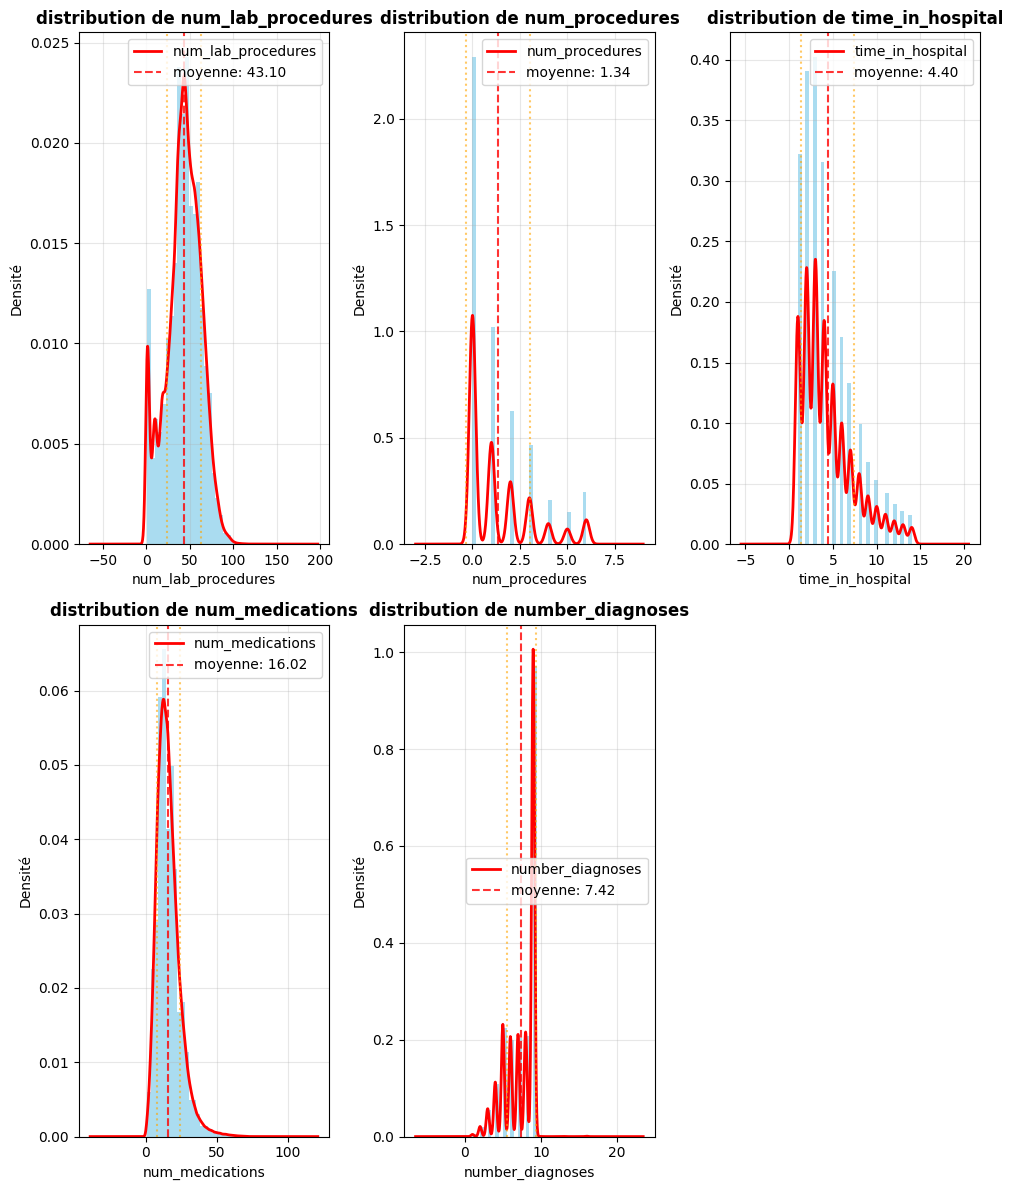

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#config des visualisations
plt.style.use("default")
sns.set_palette('husl')

#distribution des features numeriques
fig, axes = plt.subplots(2,3, figsize=(10,12))
axes  = axes.ravel()
for i, feature in enumerate(numerical_features):
  #Historamme avec courbe de densité
  ax = axes[i]
  df_diabetes[feature].hist(bins=30, ax=ax, alpha=0.7, color="skyblue", density=True)
  df_diabetes[feature].plot.density(ax=ax, color="red", linewidth=2)

  ax.set_title(f"distribution de {feature}", fontsize=12, fontweight="bold")
  ax.set_xlabel(feature)
  ax.set_ylabel("Densité")
  ax.grid(alpha=0.3)

  #stats sur le graphique
  mean_val = df_diabetes[feature].mean()
  std_val = df_diabetes[feature].std()
  ax.axvline(mean_val, color='red', linestyle="--", alpha=0.8, label=f"moyenne: {mean_val:.2f}")
  ax.axvline(mean_val-std_val, color='orange', linestyle=":", alpha=0.6)
  ax.axvline(mean_val+std_val, color='orange', linestyle=":", alpha=0.6)
  ax.legend()

#cacher les axes vides
for i in range(len(numerical_features),len(axes)):
  axes[i].set_visible(False)

plt.tight_layout()
plt.show()


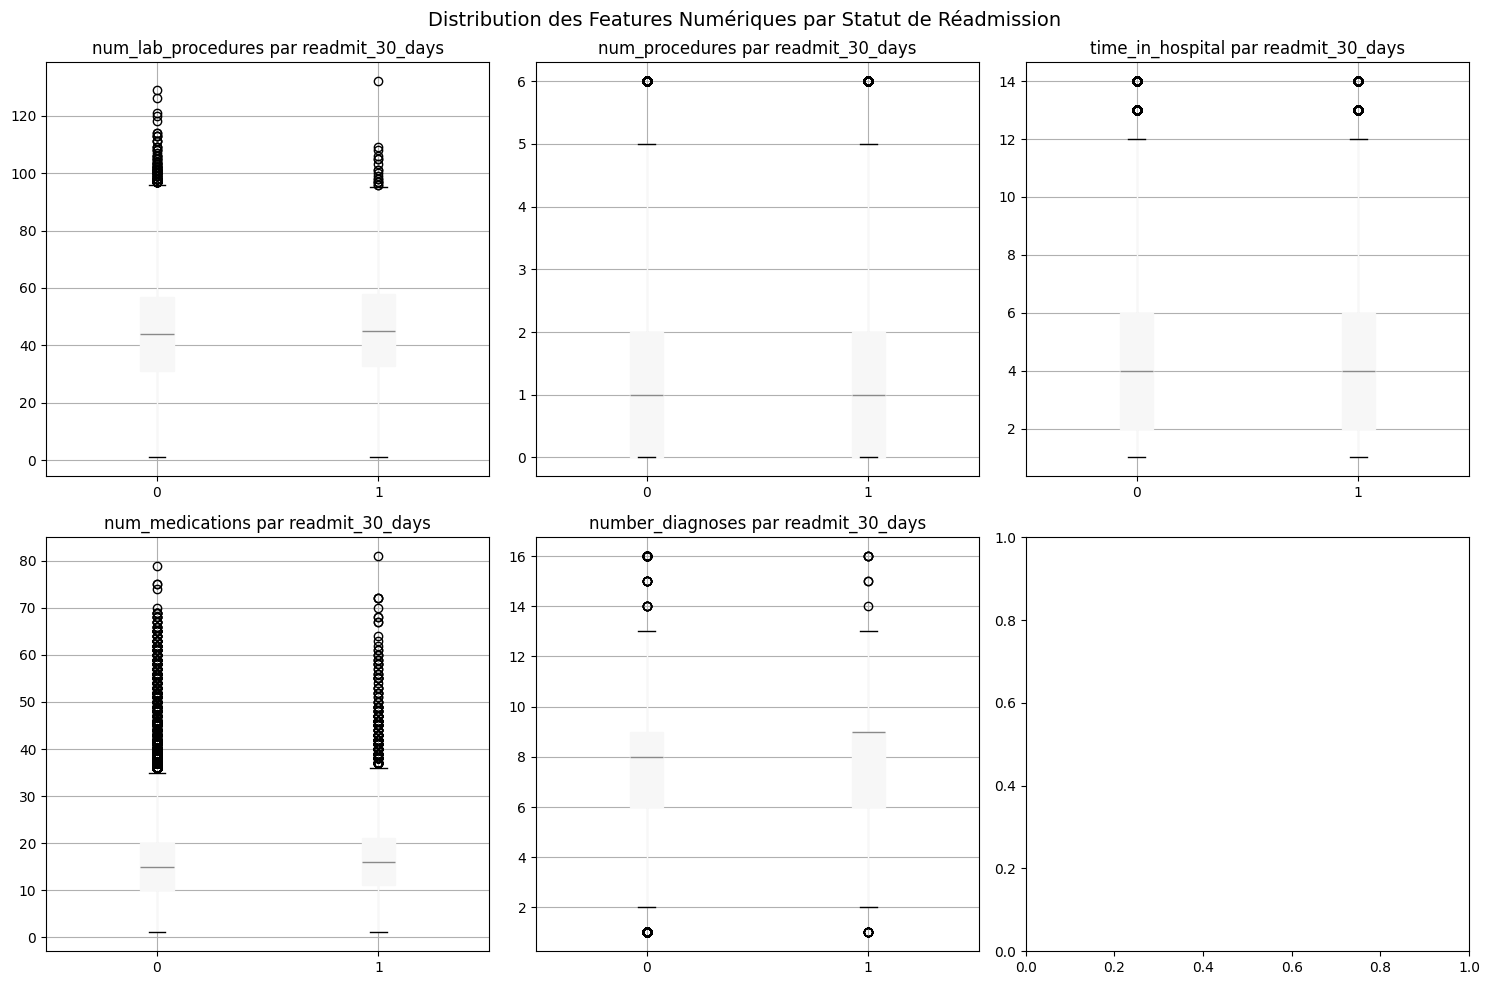

In [11]:
# Boxplots des features numériques groupées par target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    df_diabetes.boxplot(column=feature, by=label, ax=axes[i], patch_artist=True)
    axes[i].set_title(f'{feature} par {label}')
    axes[i].set_xlabel('')

plt.suptitle('Distribution des Features Numériques par Statut de Réadmission', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# Calcul des deux types de corrélation avec la target
correlation_results = []

for feature in numerical_features:
    pearson_corr = df_diabetes[feature].corr(df_diabetes[label], method='pearson')
    spearman_corr = df_diabetes[feature].corr(df_diabetes[label], method='spearman')

    correlation_results.append({
        'Feature': feature,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'Abs_Pearson': abs(pearson_corr),
        'Abs_Spearman': abs(spearman_corr)
    })

# Création du DataFrame des résultats
corr_df = pd.DataFrame(correlation_results)

# Tri par corrélation Spearman (valeur absolue)
corr_df_sorted = corr_df.sort_values('Abs_Spearman', ascending=False)

print("CORRÉLATIONS DES FEATURES NUMÉRIQUES AVEC LA TARGET")
print("="*75)
print(f"{'Feature':<25} {'Pearson':<12} {'Spearman':<12} {'Interprétation':<20}")
print("-"*75)

for _, row in corr_df_sorted.iterrows():
    # Interprétation de la force de la corrélation
    max_corr = max(abs(row['Pearson']), abs(row['Spearman']))

    if max_corr > 0.5:
        strength = "FORTE"
        color = "🟢"
    elif max_corr > 0.3:
        strength = "MOYENNE"
        color = "🟡"
    elif max_corr > 0.1:
        strength = "FAIBLE"
        color = "🟠"
    else:
        strength = "TRÈS FAIBLE"
        color = "🔴"

    # Direction de la corrélation
    direction = "positive" if row['Spearman'] > 0 else "negative"

    print(f"{row['Feature']:<25} {row['Pearson']:>10.4f}   {row['Spearman']:>10.4f}   {color} {strength} ({direction})")

CORRÉLATIONS DES FEATURES NUMÉRIQUES AVEC LA TARGET
Feature                   Pearson      Spearman     Interprétation      
---------------------------------------------------------------------------
time_in_hospital              0.0442       0.0509   🔴 TRÈS FAIBLE (positive)
number_diagnoses              0.0495       0.0472   🔴 TRÈS FAIBLE (positive)
num_medications               0.0384       0.0454   🔴 TRÈS FAIBLE (positive)
num_lab_procedures            0.0204       0.0206   🔴 TRÈS FAIBLE (positive)
num_procedures               -0.0122      -0.0061   🔴 TRÈS FAIBLE (negative)


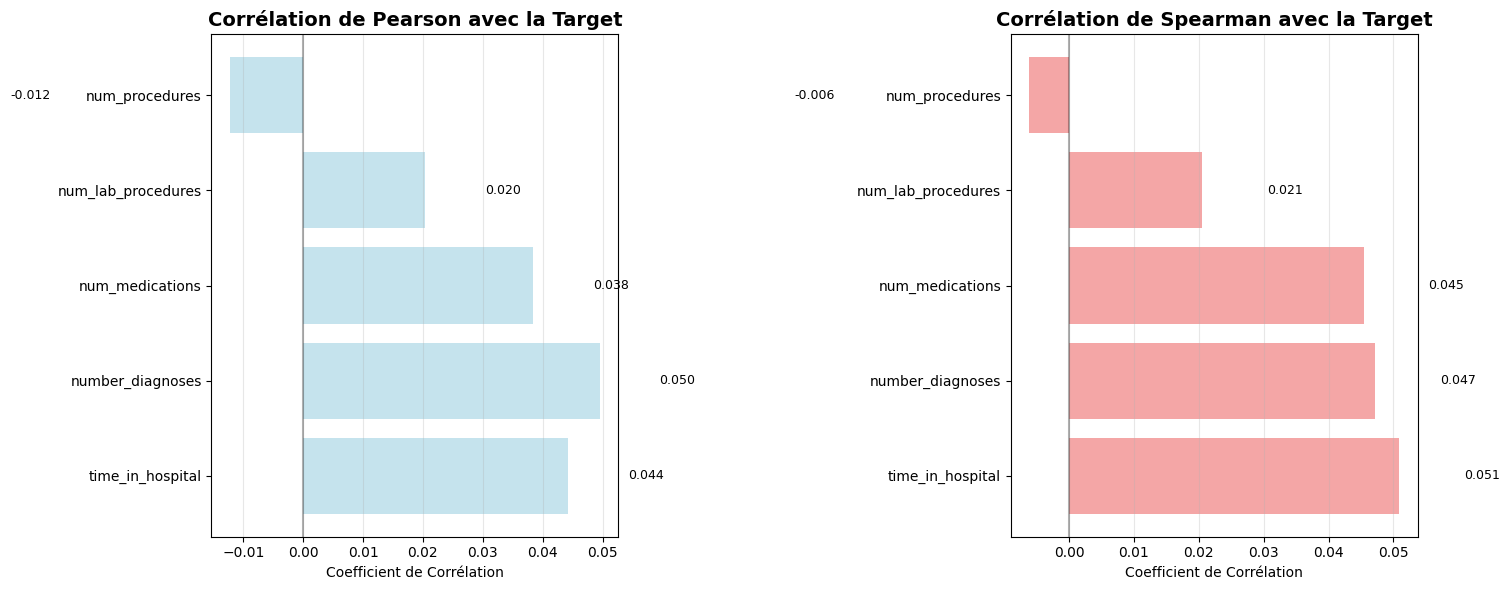

In [13]:
# Graphique des corrélations Pearson et Spearman
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
y_pos = np.arange(len(corr_df_sorted))
bars1 = ax1.barh(y_pos, corr_df_sorted['Pearson'], color='lightblue', alpha=0.7, label='Pearson')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(corr_df_sorted['Feature'])
ax1.set_xlabel('Coefficient de Corrélation')
ax1.set_title('Corrélation de Pearson avec la Target', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + (0.01 if width >= 0 else -0.03), bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

# Spearman
bars2 = ax2.barh(y_pos, corr_df_sorted['Spearman'], color='lightcoral', alpha=0.7, label='Spearman')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(corr_df_sorted['Feature'])
ax2.set_xlabel('Coefficient de Corrélation')
ax2.set_title('Corrélation de Spearman avec la Target', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + (0.01 if width >= 0 else -0.03), bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
# Statistiques descriptives et corrélations détaillées
print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE PAR FEATURE NUMÉRIQUE")
print("="*80)

for feature in numerical_features:
    print(f"\n📊 {feature}:")
    print("-" * 50)

    # Statistiques de base
    stats = df_diabetes[feature].describe()
    print(f"  Count: {stats['count']:.0f}")
    print(f"  Mean:  {stats['mean']:.2f}")
    print(f"  Std:   {stats['std']:.2f}")
    print(f"  Min:   {stats['min']:.2f}")
    print(f"  Max:   {stats['max']:.2f}")

    # Corrélations
    pearson = df_diabetes[feature].corr(df_diabetes[label], method='pearson')
    spearman = df_diabetes[feature].corr(df_diabetes[label], method='spearman')

    print(f"  Pearson:  {pearson:.4f}")
    print(f"  Spearman: {spearman:.4f}")

    # Interprétation
    if abs(spearman) > 0.1:
        direction = "positive" if spearman > 0 else "negative"
        interpretation = f"Relation {direction} avec la réadmission"
        print(f"  📈 {interpretation}")


ANALYSE DÉTAILLÉE PAR FEATURE NUMÉRIQUE

📊 num_lab_procedures:
--------------------------------------------------
  Count: 101766
  Mean:  43.10
  Std:   19.67
  Min:   1.00
  Max:   132.00
  Pearson:  0.0204
  Spearman: 0.0206

📊 num_procedures:
--------------------------------------------------
  Count: 101766
  Mean:  1.34
  Std:   1.71
  Min:   0.00
  Max:   6.00
  Pearson:  -0.0122
  Spearman: -0.0061

📊 time_in_hospital:
--------------------------------------------------
  Count: 101766
  Mean:  4.40
  Std:   2.99
  Min:   1.00
  Max:   14.00
  Pearson:  0.0442
  Spearman: 0.0509

📊 num_medications:
--------------------------------------------------
  Count: 101766
  Mean:  16.02
  Std:   8.13
  Min:   1.00
  Max:   81.00
  Pearson:  0.0384
  Spearman: 0.0454

📊 number_diagnoses:
--------------------------------------------------
  Count: 101766
  Mean:  7.42
  Std:   1.93
  Min:   1.00
  Max:   16.00
  Pearson:  0.0495
  Spearman: 0.0472


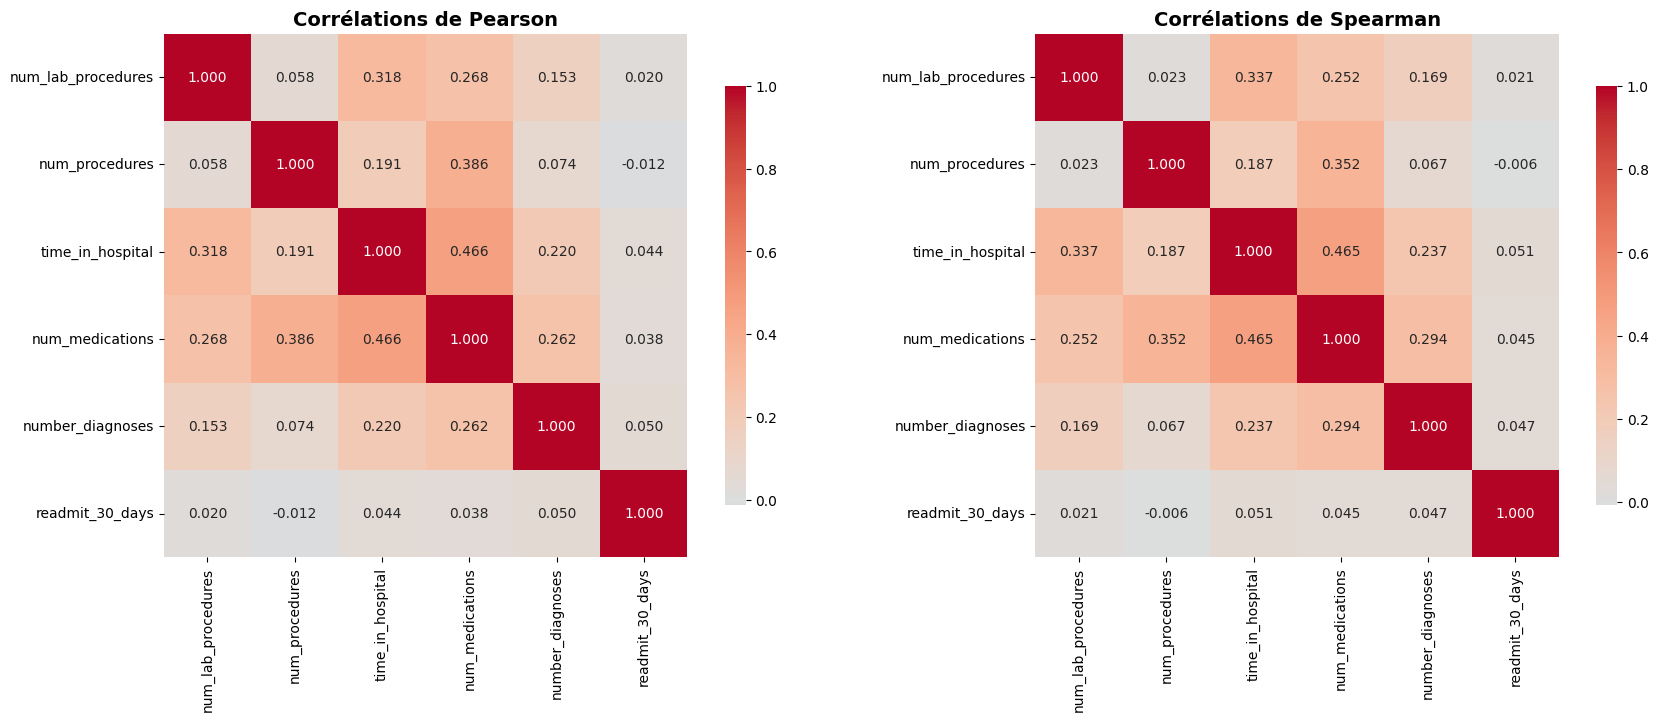

In [15]:
# Préparation des données pour heatmap
corr_matrix_pearson = df_diabetes[numerical_features + [label]].corr(method='pearson')
corr_matrix_spearman = df_diabetes[numerical_features + [label]].corr(method='spearman')

# Heatmaps côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Pearson
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': .8}, ax=ax1)
ax1.set_title('Corrélations de Pearson', fontsize=14, fontweight='bold')

# Spearman
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': .8}, ax=ax2)
ax2.set_title('Corrélations de Spearman', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# Résumé final
print("\n" + "="*70)
print("RÉSUMÉ EXÉCUTIF")
print("="*70)

print(f"\nNombre de features numériques analysées: {len(numerical_features)}")
print(f"Target variable: {label}")

# Features les plus corrélées
top_pearson = corr_df.nlargest(3, 'Abs_Pearson')
top_spearman = corr_df.nlargest(3, 'Abs_Spearman')

print(f"\nTOP 3 - Corrélation de Pearson:")
for i, (_, row) in enumerate(top_pearson.iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Pearson']:.3f}")

print(f"\nTOP 3 - Corrélation de Spearman:")
for i, (_, row) in enumerate(top_spearman.iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Spearman']:.3f}")

# Features avec corrélations significatives
significant_features = corr_df[corr_df['Abs_Spearman'] > 0.1]
print(f"\nFeatures avec corrélation significative (|Spearman| > 0.1): {len(significant_features)}")

print("\nCONCLUSION:")
print("✓ Les deux coefficients montrent des relations similaires")
print("✓ Spearman est généralement plus robuste aux outliers")
print("✓ Les features avec |corrélation| > 0.1 méritent d'être conservées")


RÉSUMÉ EXÉCUTIF

Nombre de features numériques analysées: 5
Target variable: readmit_30_days

TOP 3 - Corrélation de Pearson:
  1. number_diagnoses: 0.050
  2. time_in_hospital: 0.044
  3. num_medications: 0.038

TOP 3 - Corrélation de Spearman:
  1. time_in_hospital: 0.051
  2. number_diagnoses: 0.047
  3. num_medications: 0.045

Features avec corrélation significative (|Spearman| > 0.1): 0

CONCLUSION:
✓ Les deux coefficients montrent des relations similaires
✓ Spearman est généralement plus robuste aux outliers
✓ Les features avec |corrélation| > 0.1 méritent d'être conservées


### Question3: Display histogram of categorical distribution by label for each categorical features.

In [18]:


# Configuration pour de meilleures visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Convertir la target en catégorie pour une meilleure visualisation
df_diabetes[label] = df_diabetes[label].astype('category')
df_diabetes[label] = df_diabetes[label].cat.rename_categories({0: 'Non-Réadmis', 1: 'Réadmis'})

print(f"Features catégorielles à analyser: {categorical_features}")
print(f"Nombre de features catégorielles: {len(categorical_features)}")

Features catégorielles à analyser: ['had_emergency', 'had_inpatient_days', 'had_outpatient_days', 'age', 'gender', 'race', 'max_glu_serum', 'A1Cresult', 'insulin']
Nombre de features catégorielles: 9


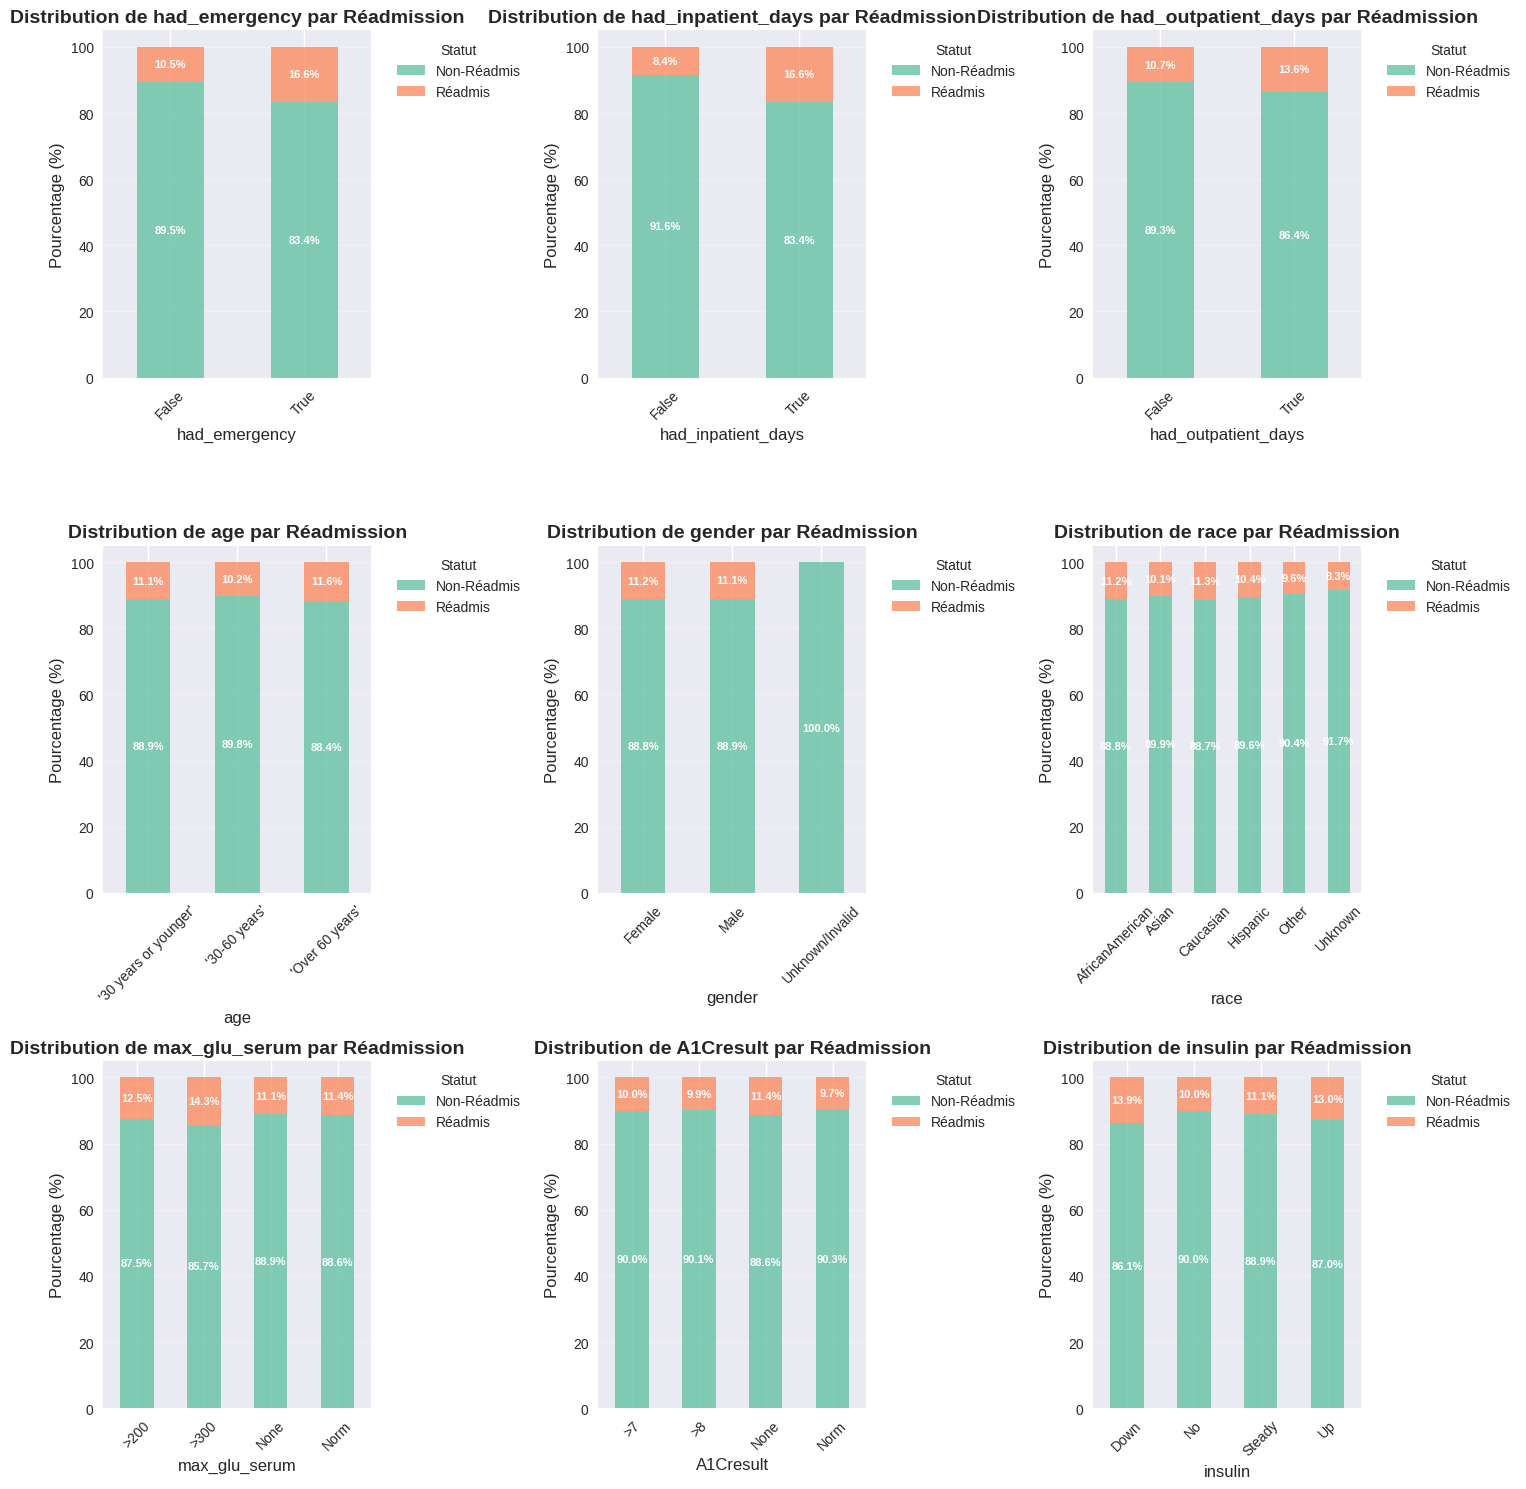

In [20]:
# Calcul du nombre de lignes et colonnes pour la grille
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Arrondi supérieur

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]  # Gérer le cas avec une seule ligne

for i, feature in enumerate(categorical_features):
    ax = axes[i]

    # Créer un DataFrame groupé pour le stacked bar chart
    cross_tab = pd.crosstab(df_diabetes[feature], df_diabetes[label], normalize='index') * 100

    # Plot stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)

    ax.set_title(f'Distribution de {feature} par Réadmission', fontsize=14, fontweight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Pourcentage (%)', fontsize=12)
    ax.legend(title='Statut', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # Ajouter les pourcentages sur les barres
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v:.1f}%' if v > 5 else '' for v in container.datavalues],
                    label_type='center', fontsize=8, color='white', fontweight='bold')

# Cacher les axes vides
for i in range(len(categorical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### Question 4: Compute base rate metrics for a sensitive binary attribute (gender, race etc)

## Part 2: MEPS dataset analysis

###  Download and simplify the dataset

In [ ]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', append=True, category=UserWarning)


In [ ]:
# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

MEPSDataset19_data = MEPSDataset19()

In [ ]:
instance_weights = MEPSDataset19_data.instance_weights
f"Dataset len {len(instance_weights)}, total weight of the dataset {instance_weights.sum()}."

### First overview of the dataset

The AIF360 library provides a wrapper around the dataset, making it a bit less intuitive to use (for example, to study/visualize the attributes one by one), but it allows fairness metrics to be computed with a single command line.

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

metric_orig_panel19_train = BinaryLabelDatasetMetric(
        MEPSDataset19_data,
        unprivileged_groups=[{'RACE': 0}],
        privileged_groups=[{'RACE': 1}])

print(metric_orig_panel19_train.disparate_impact())

However, since the aim of this lab is still to manipulate and analyze the data, we will return to working with the data in the form of a dataframe.

Note: To calculate fairness metrics without having to re-implement them for the weighted case (instance weights), you can use the methods implemented in AIF360 here: [Fairness Metrics Implementation](https://aif360.readthedocs.io/en/latest/modules/sklearn.html#module-aif360.sklearn.metrics)

### Conversion to a DataFrame

We have seen that the sum of the weights is significant, nearly 115 million, so we cannot reasonably duplicate each row as many times as its weight.

We will store the weighting and take it into account later in our analysis.

In [ ]:
def get_df(MepsDataset):
    data = MepsDataset.convert_to_dataframe()
    # data_train est un tuple, avec le data_frame et un dictionnaire avec toutes les infos (poids, attributs sensibles etc)
    df = data[0]
    df['WEIGHT'] = data[1]['instance_weights']
    return df

df_meps = get_df(MEPSDataset19_data)

In [ ]:
df_meps.columns

In [ ]:
get_metrics(
   y_true=df_meps.UTILIZATION, # list or np.array of truth values
   y_pred=None,  # list or np.array of predictions
   prot_attr=df_meps.RACE, # list or np.array of protected/sensitive attribute values
   priv_group=1, # value taken by the privileged group
   pos_label=0, # value taken by the positive truth/prediction
   sample_weight=None # list or np.array of weights value
)

In [ ]:
get_metrics(
    y_true=df_meps.UTILIZATION, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=df_meps.RACE, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=0, # value taken by the positive truth/prediction
    sample_weight=df_meps.WEIGHT # list or np.array of weights value
)

### Question 5.1 - Faire l'étude descriptive univarié de la couleur de peau ('RACE') (effectif, fréquence, model)

### Question 5.2 - Faire des graphiques décrivant la couleur de peau  (diagramme en secteur, diagramme en barres)

### Question 5.3 - Faire l'analyse bivariée entre la couleur de peau et les autres variables explicatives quantitatives (boite à moustaches des variables par genre, densité/histogramme par genre, rapport de corrélation)

### Question 5.4 - Faire l'analyse bivariée entre la couleur de peau et d'autres variables explicatives qualitative (table de contingence, diagramme en barre selon les profils lignes et selon les profils colonnes, diagramme en mosaique)

### Question 5.5 - Faire l'analyse bivariée entre la couleur de peau et la colonne 'UTILIZATION'

### Question 6 - Faire la même analyse que la question 5 avec une autre colonne sensible (sexe, âge, etc)